In [1]:
from stellargraph.data import EdgeSplitter
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.decomposition import PCA
import stellargraph as sg
import matplotlib.pyplot as plt
import networkx as nx
import common_functions as cf

## Read Graph

In [2]:
# ['0', '107']
edge_path = 'facebook/0.edges'

In [3]:
def read_graph(path):
    loaded_graph = nx.read_edgelist(path, nodetype=int, create_using=nx.Graph())
    return  sg.StellarGraph.from_networkx(loaded_graph)

def print_graph_info(graph):
    print(graph.info())

In [4]:
# Graph Info
G = read_graph(edge_path)
print_graph_info(G)

StellarGraph: Undirected multigraph
 Nodes: 333, Edges: 2519

 Node types:
  default: [333]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [2519]
        Weights: all 1 (default)
        Features: none


## Start

In [5]:
edge_splitter_test = EdgeSplitter(G)

In [6]:
# Here it takes edges from the edge_splitter test, these are the examples_test,
# Then it takes negative edges and adds them to the examples_test concatenated,
# the labels_test shows whether the edge exists or negative
# the graph_test is the graph with the remaining edges
graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(p=0.1, method="global")

** Sampled 251 positive and 251 negative edges. **


In [7]:
print_graph_info(graph_test)

StellarGraph: Undirected multigraph
 Nodes: 333, Edges: 2268

 Node types:
  default: [333]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [2268]
        Weights: all 1 (default)
        Features: none


In [8]:
edge_splitter_train = EdgeSplitter(g=graph_test, g_master=G)
graph_train, examples, labels = edge_splitter_train.train_test_split(p=0.1, method="global")

(examples_train, examples_model_selection, labels_train, labels_model_selection,)\
                                        = train_test_split(examples, labels, train_size=0.75, test_size=0.25)

** Sampled 226 positive and 226 negative edges. **


In [9]:
print_graph_info(graph_train)

StellarGraph: Undirected multigraph
 Nodes: 333, Edges: 2042

 Node types:
  default: [333]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [2042]
        Weights: all 1 (default)
        Features: none


In [10]:
pd.DataFrame(
    [
        (
            "Training Set",
            len(examples_train),
            "Train Graph",
            "Test Graph",
            "Train the Link Classifier",
        ),
        (
            "Model Selection",
            len(examples_model_selection),
            "Train Graph",
            "Test Graph",
            "Select the best Link Classifier model",
        ),
        (
            "Test set",
            len(examples_test),
            "Test Graph",
            "Full Graph",
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Hidden from", "Picked from", "Use"),
).set_index("Split")

,Number of Examples,Hidden from,Picked from,Use
Split,,,,
Training Set,339,Train Graph,Test Graph,Train the Link Classifier
Model Selection,113,Train Graph,Test Graph,Select the best Link Classifier model
Test set,502,Test Graph,Full Graph,Evaluate the best Link Classifier


In [11]:
embedding_train = cf.node2vec_embedding(graph_train, "Train Graph")

Number of random walks for 'Train Graph': 33300


In [12]:
binary_operators = [cf.operator_hadamard, cf.operator_l1, cf.operator_l2, cf.operator_avg]

In [13]:
results = [cf.run_link_prediction(op, examples_train, labels_train,
    embedding_train, examples_model_selection, labels_model_selection) for op in binary_operators]
best_result = max(results, key=lambda result: result["score"])

print(f"Best result from '{best_result['binary_operator'].__name__}'")

pd.DataFrame( [(result["binary_operator"].__name__, result["score"]) for result in results],
                    columns=("name", "ROC AUC score")).set_index("name")

Best result from 'operator_l1'


,ROC AUC score
name,
operator_hadamard,0.813910
operator_l1,0.969612
operator_l2,0.967732
operator_avg,0.701754


In [14]:
embedding_test = cf.node2vec_embedding(graph_test, "Test Graph")

Number of random walks for 'Test Graph': 33300


In [15]:
test_score = cf.evaluate_link_prediction_model(
    best_result["classifier"],
    examples_test,
    labels_test,
    embedding_test,
    best_result["binary_operator"],
)
print(f"ROC AUC score on test set using '{best_result['binary_operator'].__name__}': {test_score}")

ROC AUC score on test set using 'operator_l1': 0.9416358470500469


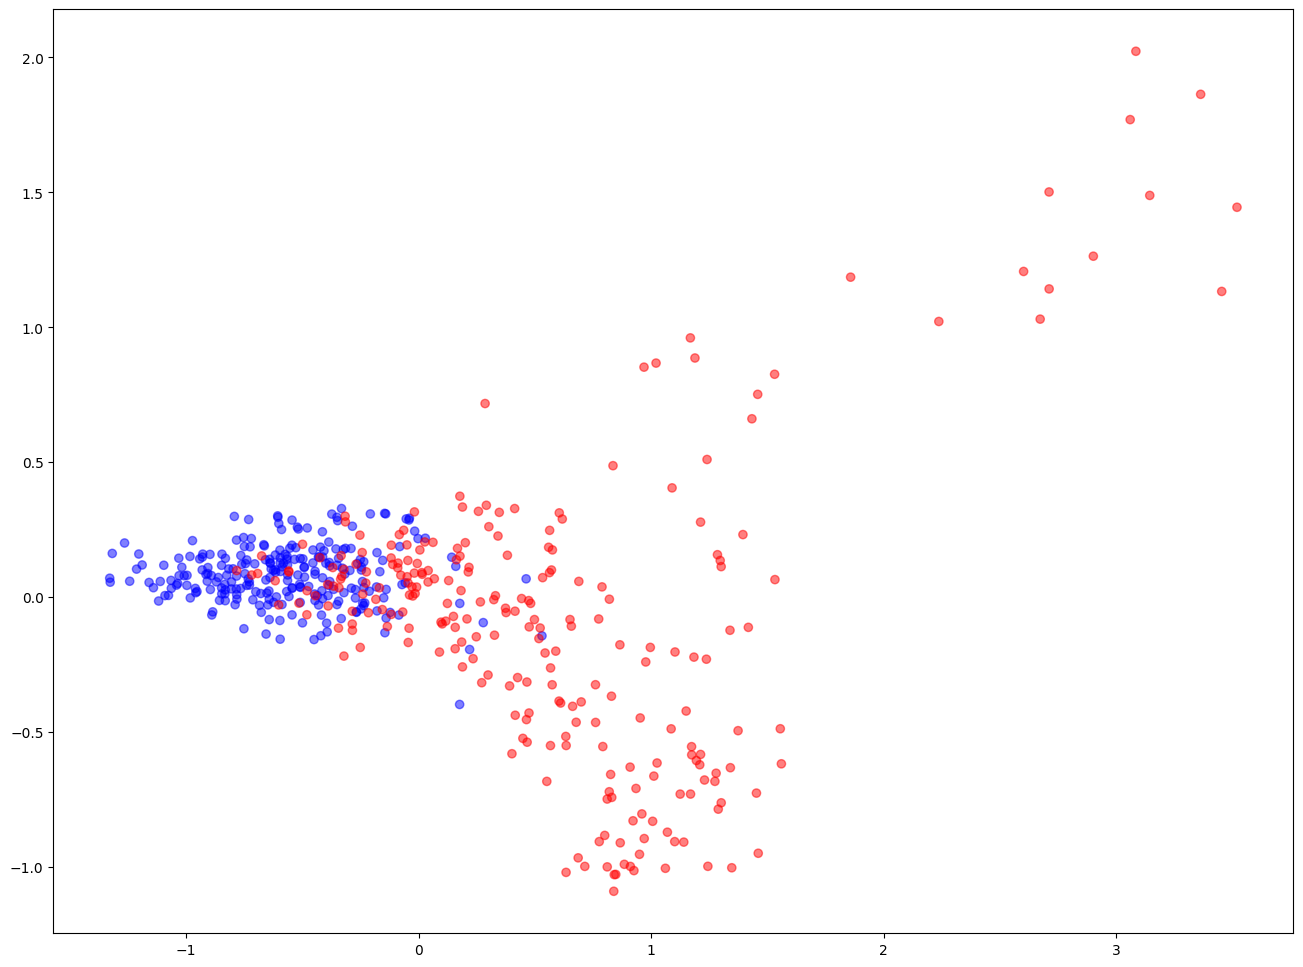

In [16]:
# Calculate edge features for test data
link_features = cf.link_examples_to_features(examples_test, embedding_test, best_result["binary_operator"])

# Learn a projection from 128 dimensions to 2
pca = PCA(n_components=2)
X_transformed = pca.fit_transform(link_features)

# plot the 2-dimensional points
plt.figure(figsize=(16, 12))
plt.scatter(
    X_transformed[:, 0],
    X_transformed[:, 1],
    c=np.where(labels_test == 1, "b", "r"),
    alpha=0.5)